(2090, 5)
RaceQuestionAnswerGeneration Initialized
len_train_data: 2090
{'input': "long long ago , there was a man who was good at shooting arrows.he asked the king to declare him as the greatest archer of the country.the king was about to do so when an old servant of the king said , `` wait , sir.i know an old man who lives in the forest.he is a much greater archer.let this young man go to him and learn from him for at least three years . `` the man could not believe what the servant said , but he went and found the old man and he was ! for three years he learned from him.then one day , when he thought he had learned everything , the thought arose in him : `` if i kill this old man , then i will be the greatest archer . `` the old man had gone to cut wood and he was coming back carrying wood on his shoulder.the young man hid behind a tree , waiting to kill him.he shot an arrow.the old man took a small piece of wood and threw it.it struck the arrow and the arrow turned back and wounded

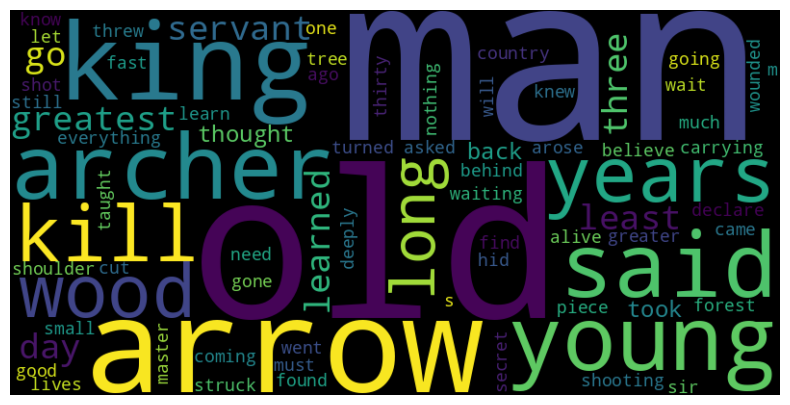

In [1]:
# !pip install transformers
import os
import sys
import random
from datetime import datetime
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim

from transformers import AutoTokenizer, AutoModelForSeq2SeqLM
import random
import torch
import numpy as np
from torch.utils.data import Dataset
import os
import json
# import torch
import pandas as pd
# import torch.nn as nn
# import torch.optim as optim
# from torch.utils.data import DataLoader
# from torch.utils.data.dataloader import default_collate
# from transformers import LongformerTokenizer

def collate_fn(list_of_items):
    """
    each item is a dictionary:
    """
    list_of_items = [x for x in list_of_items if x is not None]
    batch_size = len(list_of_items)
    if batch_size == 0: return None

    input_sequences, output_sequences = [], []
    for item in list_of_items:
        input_sequences.append(item['input'])
        output_sequences.append(item['output'])

    encoding = t5_tokenizer(
        input_sequences,
        padding="longest",
        max_length=max_length,
        truncation=True,
        return_tensors="pt",
    )
    input_ids, attention_mask = encoding.input_ids, encoding.attention_mask

    target_encoding = t5_tokenizer(
        output_sequences,
        padding="longest",
        max_length=max_length,
        truncation=True,
    )

    # the forward function automatically creates the correct decoder_input_ids
    labels = target_encoding.input_ids
    # replace padding token id's of the labels by -100 so it's ignored by the loss
    labels = torch.tensor(labels)
    labels[labels == t5_tokenizer.pad_token_id] = -100

    return {
            'input_ids': input_ids,
            'attention_mask': attention_mask,
            'labels': labels,
    }


def load_race_data(data_folder, split="train[:50%]"):
    data = []


    file_names = os.listdir(data_folder)

    for filename in file_names:
        file_path = os.path.join(data_folder, filename)
        data_value={}


        with open(file_path, "r") as file:
            json_data = json.load(file)
#             print(json_data)

        try:
            for j in (0,len(json_data['questions'])-1):
                data_value['question'] = json_data["questions"][j]
                data_value['answer'] = json_data["answers"][j]
                data_value['options'] = json_data["options"][j]
                data_value['article']=json_data["article"]
                data_value['id']=json_data["id"]
                data.append(data_value)
        except:
            print("no questions here")


    return data
data_folder = "/home/musab/Downloads/RACE/test/high"
data = load_race_data(data_folder, split="")
df = pd.DataFrame(data)

print(df.shape)

# from datasets import load_dataset
class RaceQuestionAnswerGeneration(Dataset):
    def __init__(self,data, tokenizer, data_split, separator='<sep>'):

        self.data = data
        self.tokenizer = tokenizer
        self.separator = separator
        self.label_mapping = {label: i for i, label in enumerate(["A", "B", "C", "D"])}
        print("RaceQuestionAnswerGeneration Initialized")

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        try:
          example = self.data[idx]
        except:
          print("printed None here")
          return None
        # example_id = example["example_id"]
        question = example["question"]
        context = example["article"]
        options = example["options"]
        label_example = example["answer"]
        answer = options[self.label_mapping[label_example]]

        # input & output
        input = context
        output = question + ' ' + self.separator + ' ' + answer
        return {'input': input, 'output': output}

t5_model = 't5-large'
save_dir = "model_weights/"
model_name = f"{t5_model}-Race-QA-Generation-version0"

lr0          = 5e-5
batch_size   = 8
num_workers  = 0
num_epochs   = 10
max_length   = 512
valid_step   = 5000

t5_tokenizer = AutoTokenizer.from_pretrained(t5_model, model_max_length=max_length)
t5_tokenizer.add_special_tokens({"sep_token": "<sep>"})

torch_device = 'cuda' if torch.cuda.is_available() else 'cpu'
# print("torch_device:", torch_device)

# print("model_name:", model_name)
# print("t5_model:", t5_model)
# print("lr0:", lr0)
# print("batch_size:", batch_size)
# print("num_workers:", num_workers)
# print("num_epochs:", num_epochs)
# print("valid_step:", valid_step)
# print("max_length:", max_length)


train_data = RaceQuestionAnswerGeneration(
        data=data,
        tokenizer = t5_tokenizer,
        data_split = "train",
        separator = t5_tokenizer.sep_token,
    )
    # print("here sample data : ")
    # for i in range(0,len(train_data)):
    #   print(train_data[i])
print("len_train_data:", len(train_data))
train_loader = torch.utils.data.DataLoader(
                    train_data,
                    batch_size=batch_size,
                    num_workers=num_workers,
                    shuffle=True,
                    collate_fn=collate_fn)
print(train_data[0])
!pip install WordCloud
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import re
wordcloud = WordCloud(width=800, height=400).generate(train_data[0]['input'])

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()
word_counts = []

for i in range(0,10):
    words = re.findall(r'\w+', train_data[i]['input'].lower())
    word_count = len(words)
#     print(word_count)
    word_counts.append(word_count)

# Create a bar graph
item_indices = list(range(1, 11))
# print(word_counts)
# print(item_indices)
plt.bar(item_indices, word_counts)
plt.xlabel('Train Data Item')
plt.ylabel('Word Count')
plt.xticks(item_indices)
plt.title('Passage Provided')
plt.show()


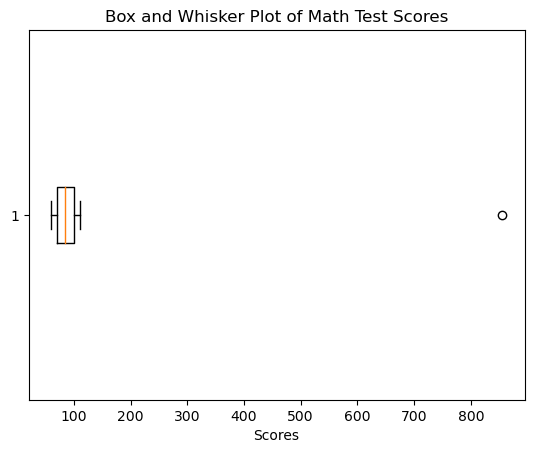

In [4]:
import matplotlib.pyplot as plt

# Sample data
data = [855, 87, 94, 77, 90, 83, 79, 93, 86, 76, 81, 72, 98, 74, 84, 99, 73, 97, 70, 100, 68, 102, 71, 103, 67, 101, 69, 105, 66, 104, 65, 106, 64, 108, 62, 107, 63, 110, 60]

# Create a box and whisker plot
plt.boxplot(data, vert=False)  # "vert=False" for horizontal plot
plt.title('Box and Whisker Plot of Math Test Scores')
plt.xlabel('Scores')
plt.show()

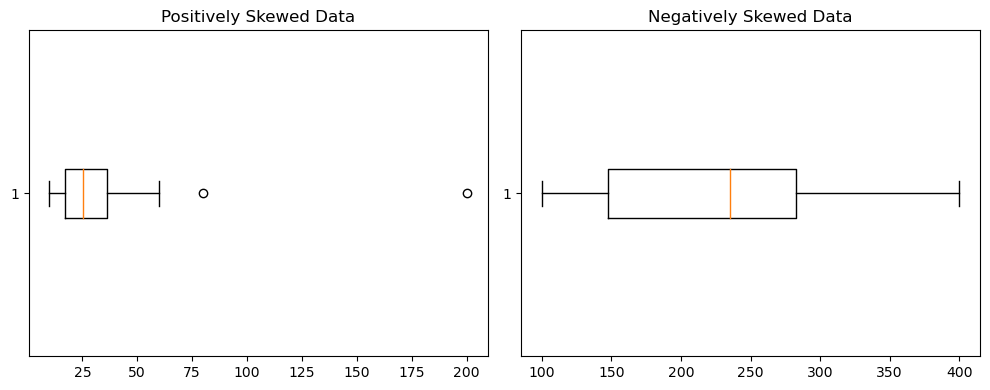

In [5]:
import matplotlib.pyplot as plt

# Sample data
positively_skewed_data = [10, 12, 14, 15, 18, 20, 22, 25, 26, 28, 30, 35, 40, 60, 80, 200]
negatively_skewed_data = [400, 350, 300, 290, 280, 270, 260, 250, 220, 200, 180, 150, 140, 130, 120, 100]

# Create subplots for both plots
fig, axes = plt.subplots(1, 2, figsize=(10, 4))

# Plot for positively skewed data
axes[0].boxplot(positively_skewed_data, vert=False)
axes[0].set_title('Positively Skewed Data')

# Plot for negatively skewed data
axes[1].boxplot(negatively_skewed_data, vert=False)
axes[1].set_title('Negatively Skewed Data')

plt.tight_layout()
plt.show()
